Import required libraries

In [1]:
import cv2
import numpy as np
import os
import requests

from collections import Counter

loading model to memory

In [2]:
#check whether the file_path exists, otherwise download the file from given url
def download_and_prepare_file(file_path,url):
    if not os.path.exists(file_path):
        response = requests.get(url)
        with open(file_path, 'wb') as local_file:
            local_file.write(response.content)
        assert os.path.exists(file_path), f'{{file_path}} file not found.'
    return file_path

#verify model configuration, weights and label files.
def get_model_files():    
    config_file = download_and_prepare_file('./model_data/config.cfg','https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-spp.cfg')
    weights_file = download_and_prepare_file('./model_data/weights','https://pjreddie.com/media/files/yolov3-spp.weights')
    labels_file = download_and_prepare_file('./model_data/labels','https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names' )
    
    return config_file, weights_file, labels_file

# load the model from the given files
def load_model(config_file, weights_file, labels_file):
    model = cv2.dnn.readNet(weights_file,config_file)
    labels=[]
    with open(labels_file) as file:
        labels = file.read().splitlines()
    return model, labels

get all output layers (YOLO has several output layers)

In [3]:
# get all output layers of the given model.
def get_output_layer_names(model):
    layers = model.getLayerNames() # get all layer names
    outputs = [layers[i-1] for i in model.getUnconnectedOutLayers()] # filter names of the unconnected layers (outputs)
    return outputs

Test run on jupyter notebook

In [4]:
def filter_results(boxes,confidences,class_ids,labels):
    conf_threshold = 0.5
    nms_threshold = 0.4
    # apply non-max suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    results = [labels[class_ids[i]] for i in indices]
    results_count = Counter(results)
    return dict(results_count)

In [5]:
def make_predictions(model,labels,image_blob,width,height):
    model.setInput(image_blob)
    outputs = model.forward(output_layers)
    class_ids = []
    confidences = []
    boxes = []
    for output in outputs:
        for detection in output:
            scores= detection[5:]
            class_idx = np.argmax(scores)
            confidence = scores[class_idx]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_idx)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])
                
    return filter_results(boxes,confidences,class_ids,labels)

./model_data/config.cfg ./model_data/weights ./model_data/labels


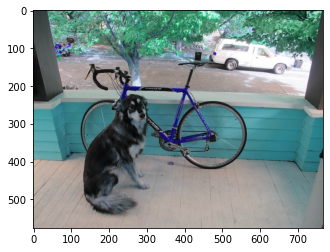

{'dog': 1, 'bicycle': 1, 'truck': 1}


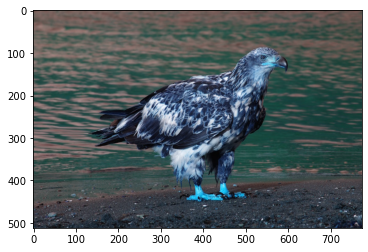

{'bird': 1}


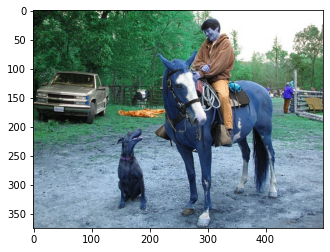

{'horse': 1, 'person': 4, 'dog': 1, 'truck': 1}


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
config_file, weights_file, labels_file = get_model_files()
scale = 1/255
model,labels = load_model(config_file, weights_file, labels_file)
output_layers = get_output_layer_names(model)

dog_image = download_and_prepare_file('./dog.jpg','https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg')
eagle_image = download_and_prepare_file('./eagle.jpg','https://raw.githubusercontent.com/pjreddie/darknet/master/data/eagle.jpg')
horse_image = download_and_prepare_file('./horse.jpg','https://raw.githubusercontent.com/pjreddie/darknet/master/data/horses.jpg')
images = [dog_image, eagle_image, horse_image]

for image in images:
    sample_image = cv2.imread(image)
    width = sample_image.shape[1]
    height = sample_image.shape[0]
    image_blob = cv2.dnn.blobFromImage(sample_image, scale, (416,416), (0,0,0), True, crop=False)
    plt.imshow(sample_image)
    plt.show()
    
    results = make_predictions(model,labels,image_blob,width,height)
    
    print(results)
    
        